In [46]:
#import required libraries

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow

In [47]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [45]:
#downloading dataset

!kaggle competitions download -c dogs-vs-cats

100% 812M/812M [00:10<00:00, 203MB/s]
100% 812M/812M [00:10<00:00, 79.8MB/s]


In [48]:
!unzip -q dogs-vs-cats.zip -d /content/

In [50]:
!unzip -q train.zip -d /content/

In [49]:
!unzip -q test1.zip -d /content/

In [52]:
#splitting and organnizing data into folders of train/validation/test

import os, shutil, random

original_dir = '/content/train'
base_dir = '/content/data'

# Create subfolders
for split in ['train', 'validation', 'test']:
    for category in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# Split and move files
def split_data(animal):
    files = [f for f in os.listdir(original_dir) if f.startswith(animal)]
    random.shuffle(files)
    total = len(files)
    train_end = int(0.7 * total)
    val_end = int(0.9 * total)

    for i, file in enumerate(files):
        src = os.path.join(original_dir, file)
        if i < train_end:
            dst = os.path.join(base_dir, 'train', animal + 's', file)
        elif i < val_end:
            dst = os.path.join(base_dir, 'validation', animal + 's', file)
        else:
            dst = os.path.join(base_dir, 'test', animal + 's', file)
        shutil.copyfile(src, dst)

split_data('cat')
split_data('dog')

In [53]:
#image generator with data augmentation

import cv2
import numpy as np
import os
from tensorflow.keras.utils import Sequence

class DogCatDataset(Sequence):
    def __init__(self, folder, batch_size=32, image_size=(200, 200), shuffle=True, is_training=False):
        self.image_size = image_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.is_training = is_training

        self.data = []
        self.labels = []

        for label, subfolder in enumerate(['cats', 'dogs']):
            folder_path = os.path.join(folder, subfolder)
            for fname in os.listdir(folder_path):
                self.data.append(os.path.join(folder_path, fname))
                self.labels.append(label)

        self.data = np.array(self.data)
        self.labels = np.array(self.labels)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_x = self.data[index * self.batch_size : (index + 1) * self.batch_size]
        batch_y = self.labels[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        for path in batch_x:
            img = cv2.imread(path)
            img = cv2.resize(img, self.image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


            if self.is_training:
                if np.random.rand() < 0.5:
                    img = cv2.flip(img, 1)

                angle = np.random.uniform(-20, 20)
                h, w = img.shape[:2]
                M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1)
                img = cv2.warpAffine(img, M, (w, h))

                alpha = np.random.uniform(0.8, 1.2)
                beta = np.random.uniform(-10, 10)
                img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

            img = img / 255.0
            images.append(img)

        return np.array(images), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            idx = np.arange(len(self.data))
            np.random.shuffle(idx)
            self.data = self.data[idx]
            self.labels = self.labels[idx]

In [54]:
train_gen = DogCatDataset("data/train", batch_size=32, is_training=True)
val_gen = DogCatDataset("data/validation", batch_size=32, is_training=False)

In [59]:
#model architecture

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [77]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,077,637 (7.93 MB)

 Trainable params: 692,545 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,385,092 (5.28 MB)

In [62]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [63]:
model.fit(train_gen, validation_data=val_gen, epochs=7)

Epoch 1/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 125s 163ms/step - accuracy: 0.5040 - loss: 0.6925 - val_accuracy: 0.5274 - val_loss: 0.6953
Epoch 2/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 87s 122ms/step - accuracy: 0.6131 - loss: 0.6565 - val_accuracy: 0.6947 - val_loss: 0.5944
Epoch 3/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 85s 119ms/step - accuracy: 0.6728 - loss: 0.6033 - val_accuracy: 0.6878 - val_loss: 0.5854
Epoch 4/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 141s 118ms/step - accuracy: 0.7237 - loss: 0.5509 - val_accuracy: 0.7791 - val_loss: 0.4873
Epoch 5/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 148s 125ms/step - accuracy: 0.7680 - loss: 0.4839 - val_accuracy: 0.8153 - val_loss: 0.4073
Epoch 6/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.8072 - loss: 0.4246 - val_accuracy: 0.7884 - val_loss: 0.4377
Epoch 7/7
712/712 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.8361 - loss: 0.3753 - val_accuracy: 0.8709 - val_loss: 0.2999


In [64]:
model.fit(train_gen, validation_data=val_gen, epochs=3)

Epoch 1/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 87s 123ms/step - accuracy: 0.8548 - loss: 0.3380 - val_accuracy: 0.8736 - val_loss: 0.3036
Epoch 2/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 142s 122ms/step - accuracy: 0.8718 - loss: 0.2988 - val_accuracy: 0.8909 - val_loss: 0.2645
Epoch 3/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 86s 120ms/step - accuracy: 0.8806 - loss: 0.2850 - val_accuracy: 0.9096 - val_loss: 0.2256


In [65]:
model.fit(train_gen, validation_data=val_gen, epochs=3)

Epoch 1/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 84s 118ms/step - accuracy: 0.8916 - loss: 0.2538 - val_accuracy: 0.9166 - val_loss: 0.2028
Epoch 2/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 82s 116ms/step - accuracy: 0.9041 - loss: 0.2306 - val_accuracy: 0.9200 - val_loss: 0.1931
Epoch 3/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 87s 122ms/step - accuracy: 0.9037 - loss: 0.2258 - val_accuracy: 0.9197 - val_loss: 0.1952


In [78]:
model.fit(train_gen, validation_data=val_gen, epochs=3)

Epoch 1/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 96s 135ms/step - accuracy: 0.9181 - loss: 0.2080 - val_accuracy: 0.9010 - val_loss: 0.2483
Epoch 2/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 105s 147ms/step - accuracy: 0.9063 - loss: 0.2237 - val_accuracy: 0.9338 - val_loss: 0.1639
Epoch 3/3
712/712 ━━━━━━━━━━━━━━━━━━━━ 83s 116ms/step - accuracy: 0.9165 - loss: 0.2022 - val_accuracy: 0.9189 - val_loss: 0.1997


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step


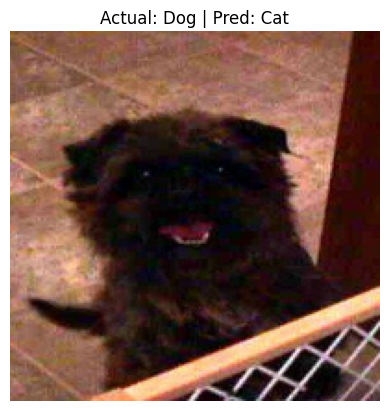

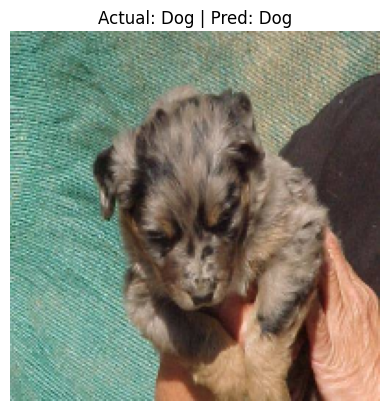

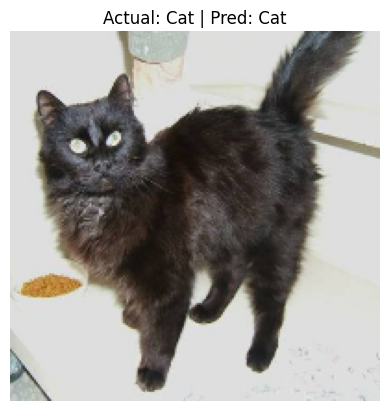

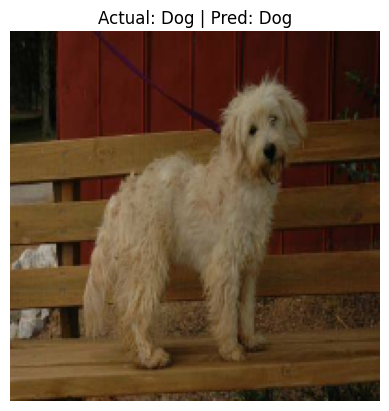

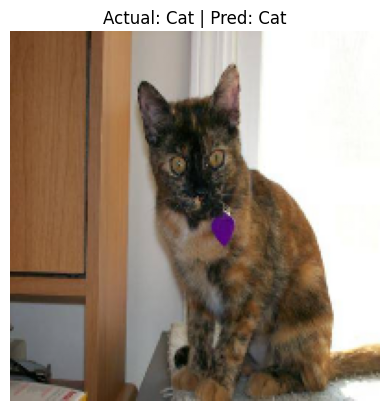

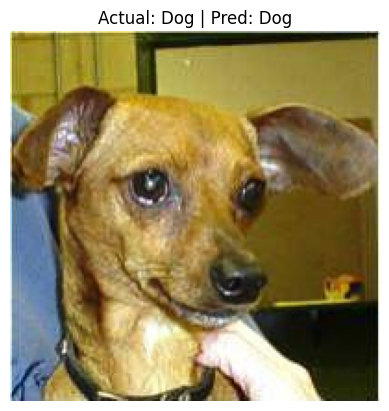

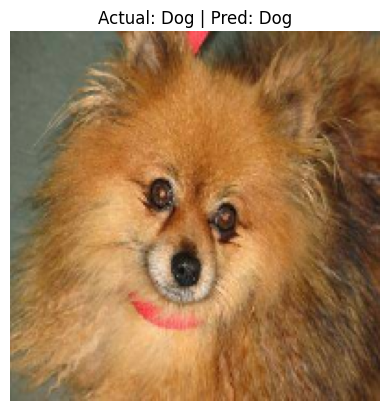

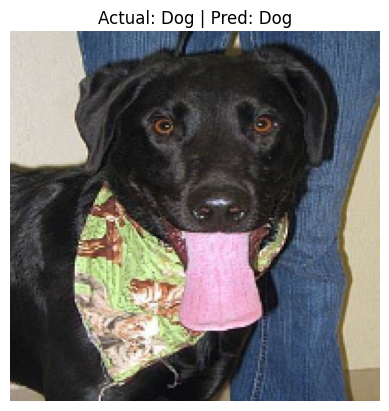

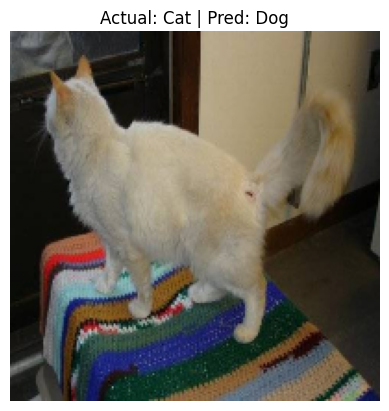

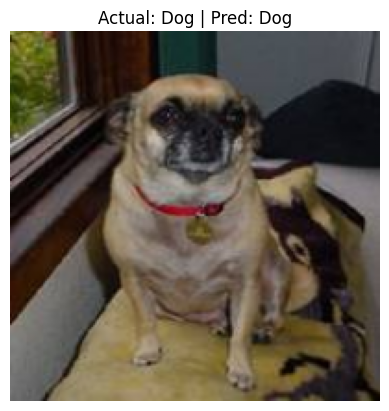

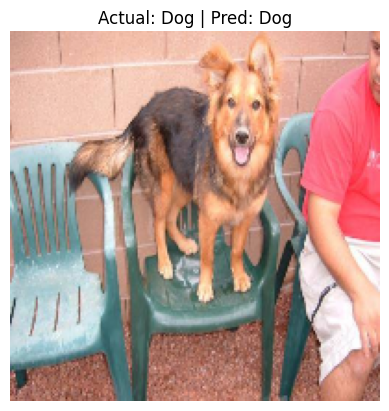

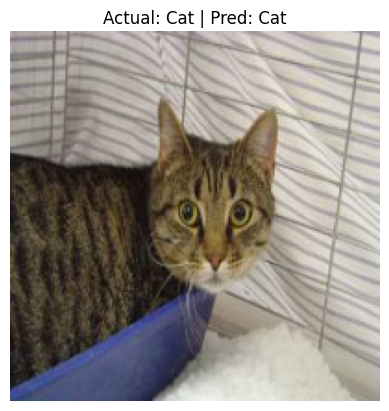

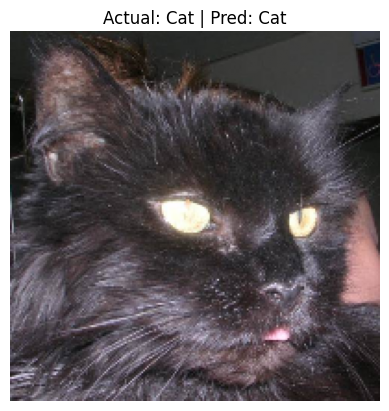

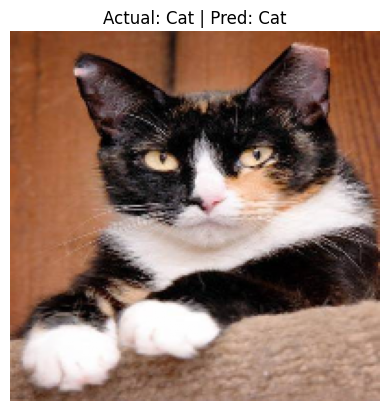

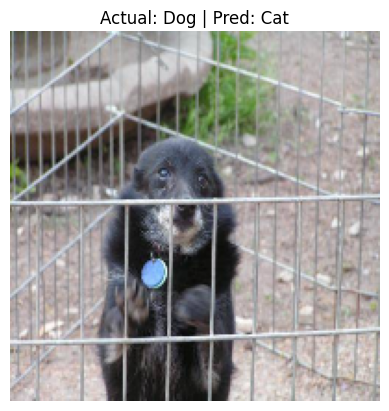

In [66]:
#model predictions for a random batch

import matplotlib.pyplot as plt

X_batch, y_batch = val_gen[13]

preds = model.predict(X_batch)

#show first 10 predictions
for i in range(10):
    plt.imshow(X_batch[i])
    plt.title(f"Actual: {'Dog' if y_batch[i] == 1 else 'Cat'} | Pred: {'Dog' if preds[i] > 0.5 else 'Cat'}")
    plt.axis('off')
    plt.show()

In [79]:
test_gen = DogCatDataset('/content/data/test', batch_size=32, shuffle=True, is_training=False)

In [80]:
#evaluating model on test data

y_true = []
y_pred = []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    preds = model.predict(X_batch,verbose=0)
    y_true.extend(y_batch)
    y_pred.extend((preds > 0.5).astype(int).flatten())

In [81]:
#accuracy score

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9208


In [82]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

Confusion Matrix:
[[2072  314]
 [  62 2300]]

Classification Report:
              precision    recall  f1-score   support

         Cat       0.97      0.87      0.92      2386
         Dog       0.88      0.97      0.92      2362

    accuracy                           0.92      4748
   macro avg       0.93      0.92      0.92      4748
weighted avg       0.93      0.92      0.92      4748



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


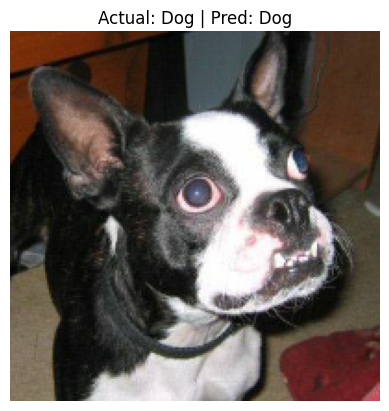

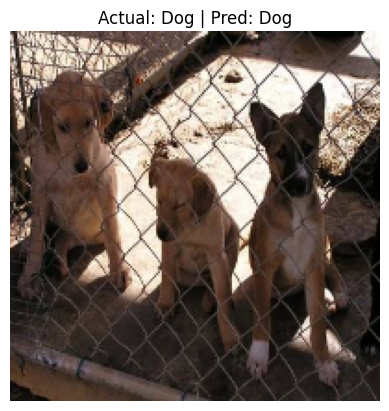

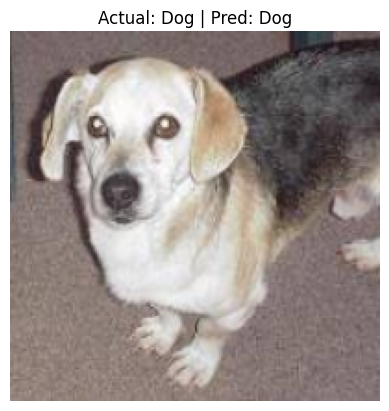

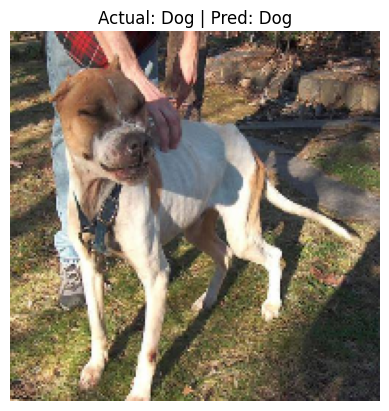

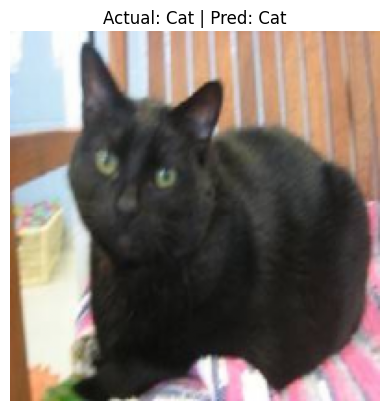

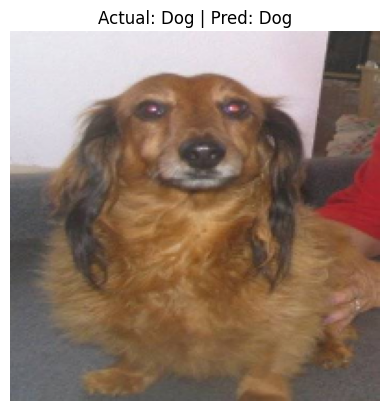

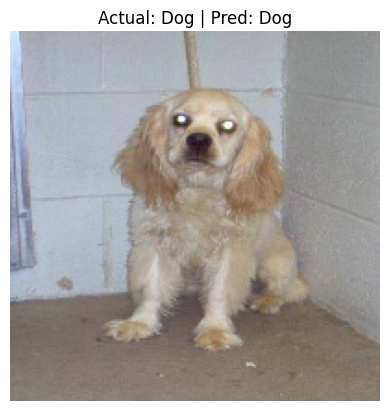

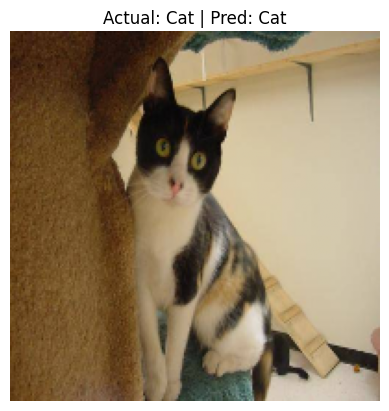

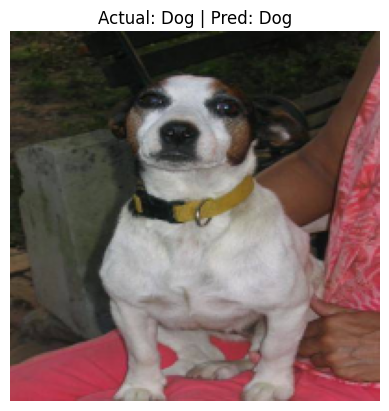

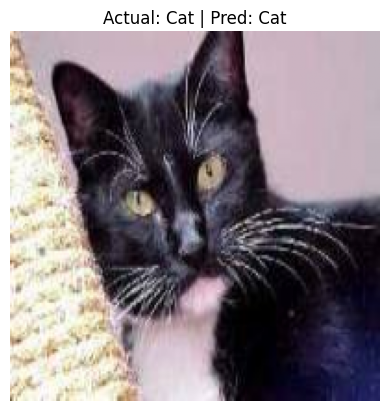

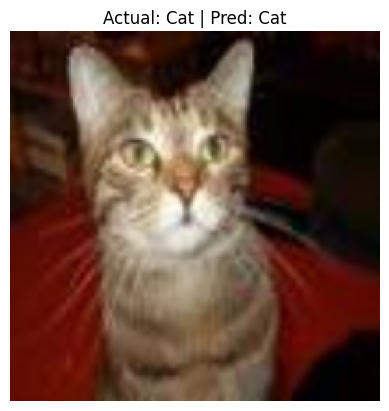

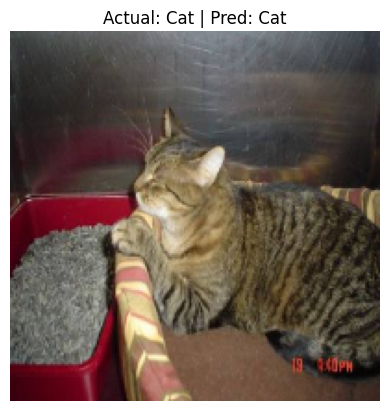

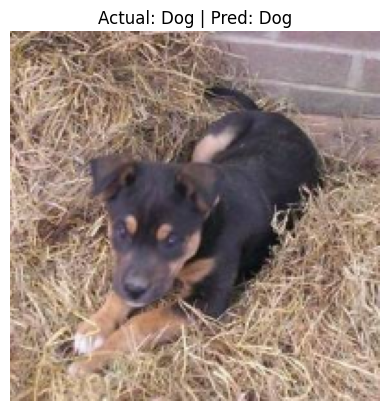

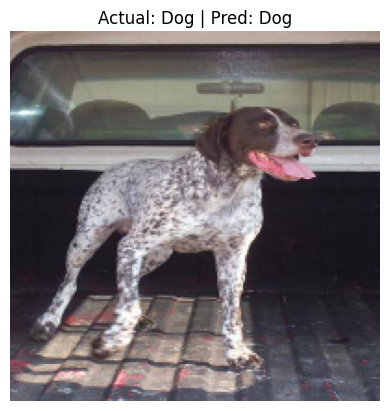

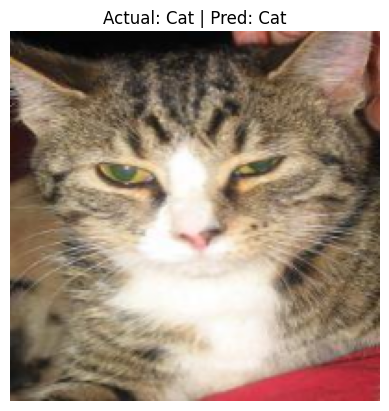

In [85]:
import matplotlib.pyplot as plt

# Get a batch
X_batch, y_batch = test_gen[12]  # First batch

# Make predictions
preds = model.predict(X_batch)

# Show first 5 images and predictions
for i in range(15):
    plt.imshow(X_batch[i])
    plt.title(f"Actual: {'Dog' if y_batch[i] == 1 else 'Cat'} | Pred: {'Dog' if preds[i] > 0.5 else 'Cat'}")
    plt.axis('off')
    plt.show()

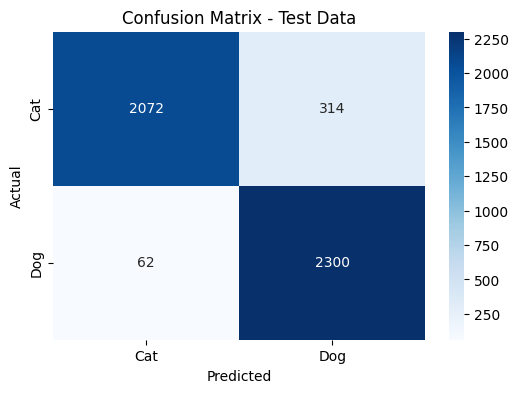

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cat", "Dog"], yticklabels=["Cat", "Dog"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Data")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


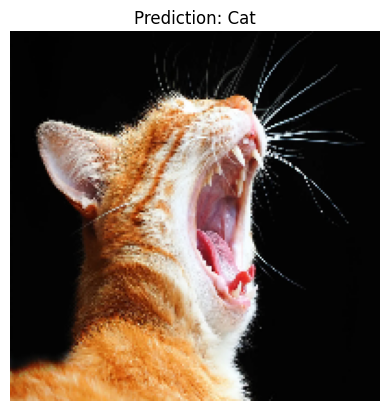

The model predicts: Cat


In [84]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path to the custom image
img_path = '/content/Orange-colored-cat-yawns-displaying-teeth.jpg'  # Replace with your image path

# Load and preprocess the image
img = cv2.imread(img_path)
img_resized = cv2.resize(img, (200, 200))  # Resize to the input shape of your model
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
img_normalized = img_rgb / 255.0  # Normalize the image

# Reshape the image to match the model input (batch size, height, width, channels)
img_batch = np.expand_dims(img_normalized, axis=0)  # Shape should be (1, 200, 200, 3)

# Make the prediction
prediction = model.predict(img_batch)

# Interpret the prediction
prediction_label = "Dog" if prediction[0] > 0.5 else "Cat"

# Display the image
plt.imshow(img_rgb)
plt.axis('off')  # Turn off the axis
plt.title(f"Prediction: {prediction_label}")
plt.show()

# Output the prediction result
print(f"The model predicts: {prediction_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


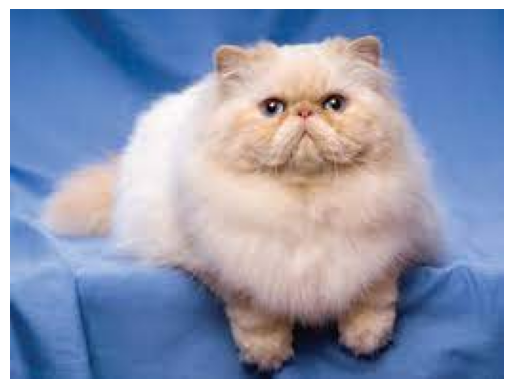

Predicted Label: Cat


In [86]:
import cv2
import numpy as np
import requests

# URL of the image
image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS66gAz6eVgMTiXYpscREdbb5ba4gJrEuOGT1Is7UxGazYCLsedIq0p40C78pagf0p7pGM&usqp=CAU'  # Replace with the actual URL

# Step 1: Fetch the image content using requests
response = requests.get(image_url)

# Step 2: Convert the content to a NumPy array
img_array = np.frombuffer(response.content, np.uint8)

# Step 3: Decode the image into an OpenCV format
img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)

# Step 4: Resize and preprocess the image (same as before)
img_resized = cv2.resize(img, (200, 200))  # Resize to match model input size
img_normalized = img_resized / 255.0  # Normalize to [0, 1]

# Step 5: Expand dimensions for prediction
img_expanded = np.expand_dims(img_normalized, axis=0)

# Step 6: Predict using the trained model
prediction = model.predict(img_expanded)

# Show the image (optional)
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Step 7: Print the result (0 = cat, 1 = dog)
print("Predicted Label:", "Dog" if prediction[0] > 0.5 else "Cat")

In [87]:
model.save('/content/catvsdog.h5')